# Instacart Market Basket Analysis Exploratory Data Analysis

### By Philip Sparks

In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import sklearn as sk
import scipy
%matplotlib inline

#### From GitHub, these descriptions will help with wrangling the data into the correct format for discovery and analysis.

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

### Convert all tables to the Pandas Data Frames we will eventually be working with.



In [2]:
aisles = pd.DataFrame.from_csv('instacart_2017_05_01/aisles.csv')

departments = pd.DataFrame.from_csv('instacart_2017_05_01/departments.csv')

order_products__priors = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__prior.csv')

order_products__train = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__train.csv')

orders = pd.DataFrame.from_csv('instacart_2017_05_01/orders.csv')

products = pd.DataFrame.from_csv('instacart_2017_05_01/products.csv')

### Check the heads of the data to see samples and confirm data is loaded.

In [ ]:
aisles.head()

In [ ]:
departments.head(25)

In [ ]:
order_products__priors.head(10)

In [ ]:
order_products__train.head(10)

In [ ]:
orders.sort_index().head()

In [ ]:
products.head(10)

### Check for null values.

In [3]:
print aisles.isnull().any()
print departments.isnull().any()
print orders.isnull().any()
print products.isnull().any()

aisle    False
dtype: bool
department    False
dtype: bool
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool
product_name     False
aisle_id         False
department_id    False
dtype: bool


### Determine the same with the product orders.

In [ ]:
print order_products__priors.isnull().any()
print order_products__train.isnull().any()

### orders : days_since_prior_order has NaN. We'll change that to "0" to have numerical values throughout the set.

In [ ]:
orders.fillna(value = 0).head(5)

In [ ]:
print orders.isnull().any()

In [ ]:
#orders.describe()

### Append training and prior sets to create a data frame with all rows for merging.

In [8]:
orders_products_full = order_products__priors.append(order_products__train)

In [5]:
orders.sort_index().head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1,112108,train,4,4,10,9.0
2,202279,prior,3,5,9,8.0
3,205970,prior,16,5,17,12.0
4,178520,prior,36,1,9,7.0
5,156122,prior,42,6,16,9.0


In [6]:
orders_products_full.sort_index().head()

,product_id,add_to_cart_order,reordered
order_id,,,
1,49302,1,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0


### Merge the data frames into one for future EDA and analysis.

In [12]:
orders_join_1 = pd.merge(orders, orders_products_full, left_index = True, right_index = True, how = 'left')

In [13]:
orders_join_1.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
order_id,,,,,,,,,
1,112108,train,4,4,10,9.0,49302.0,1.0,1.0
1,112108,train,4,4,10,9.0,11109.0,2.0,1.0
1,112108,train,4,4,10,9.0,10246.0,3.0,0.0
1,112108,train,4,4,10,9.0,49683.0,4.0,0.0
1,112108,train,4,4,10,9.0,43633.0,5.0,1.0


In [14]:
orders_join_2 = pd.merge(orders_join_1, products, left_on = 'product_id', right_index = True, how = 'left')

In [15]:
orders_join_2.head(5)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
order_id,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120.0,16.0
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108.0,16.0
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83.0,4.0
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83.0,4.0
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95.0,15.0


In [ ]:
aisles.head(20)

In [16]:
orders_final = pd.merge(orders_join_2, aisles, left_on = 'aisle_id', right_index = True, how = 'left')

In [19]:
orders_final

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95,15.0,canned meat seafood
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs


### Data Frames to use for EDA

In [ ]:
#aisles
#departments
#order_products__priors
#order_products__train
#orders
#products
#orders_final

In [37]:
orders_final.product_name.value_counts().head(25)

Banana                        491291
Bag of Organic Bananas        394930
Organic Strawberries          275577
Organic Baby Spinach          251705
Organic Hass Avocado          220877
Organic Avocado               184224
Large Lemon                   160792
Strawberries                  149445
Limes                         146660
Organic Whole Milk            142813
Organic Raspberries           142603
Organic Yellow Onion          117716
Organic Garlic                113936
Organic Zucchini              109412
Organic Blueberries           105026
Cucumber Kirby                 99728
Organic Fuji Apple             92889
Organic Lemon                  91251
Organic Grape Tomatoes         88078
Apple Honeycrisp Organic       87272
Seedless Red Grapes            86748
Organic Cucumber               85005
Honeycrisp Apple               83320
Organic Baby Carrots           80493
Sparkling Water Grapefruit     79245
Name: product_name, dtype: int64

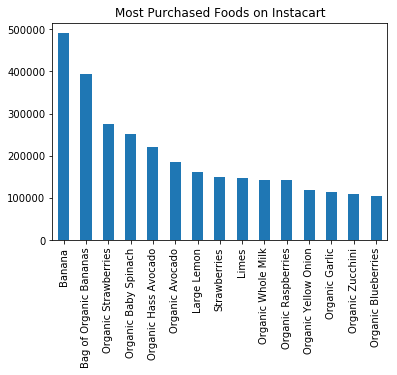

In [36]:
orders_final.product_name.value_counts().head(15).plot(kind = 'bar', title = 'Most Purchased Foods on Instacart')

In [ ]:
orders_final.order_dow.value_counts().sort_index()

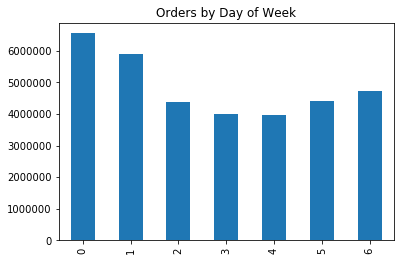

In [18]:
orders_final.order_dow.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Day of Week')

In [ ]:
orders_final.order_hour_of_day.value_counts().sort_index()

In [ ]:
orders.order_hour_of_day.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Hour of the Day')

In [ ]:
orders.days_since_prior_order.value_counts().sort_index()

In [ ]:
#orders.days_since_prior_order.value_counts().sort_index().plot(kind = 'bar', title = 'Days Since Previous Order')

In [ ]:
#orders_final.describe()
#this takes awhile, couple minutes

In [ ]:
orders_final.shape

In [17]:
orders_final.sort_values(['user_id', 'order_number']) # this also takes a long time
orders_final_short = orders_final[:100000]
orders_final_short.shape

(100000, 13)

### Exploratory Charts

In [ ]:
orders_final_short.days_since_prior_order.value_counts().sort_index().plot(kind = 'bar', title = 'Days Since Previous Order')

In [ ]:
orders_final_short.dtypes

In [ ]:
orders_final_short.product_name.value_counts().head(25)

In [ ]:
#orders_final_short.sum()

In [ ]:
orders_final_short.hist(bins=50, figsize=(20,15))

In [ ]:
corr_matrix = orders_final_short.corr()

In [ ]:
corr_matrix["days_since_prior_order"].sort_values(ascending=False)

In [ ]:
corr_matrix["reordered"].sort_values(ascending=False)

In [ ]:
#pd.plotting.scatter_matrix(orders_final_short, figsize=(12, 8))

In [ ]:
orders_final_short.groupby('reordered')['add_to_cart_order'].mean()
# Users who were reordering were ordering ~1.8 items less?

In [ ]:
orders_final_short.groupby('reordered')['add_to_cart_order'].mean().plot(kind = 'bar', title = 'First Order vs. Reorder')

In [ ]:
heat_corr = orders_final_short.corr()
heat_corr = (heat_corr)

sns.heatmap(heat_corr, 
            xticklabels= heat_corr.columns.values,
            yticklabels= heat_corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
heat_corr

In [ ]:
# join on the user_id, and loop through the rows
# create a py dict,take  that list of rows
#for each user that has at least two rows, 
# create two values,
# 1. target Y, get the days since prior order
# 2. get average days since prior order


In [11]:
orders_subset = orders_final_short[['user_id', 'days_since_prior_order']]
len(orders_subset['user_id'][:-1])

99999

In [ ]:
#corr_matrix['product_id'].sort_values(ascending=False)

In [ ]:
# orders_subset = orders_final_short[['user_id', 'days_since_prior_order']]
# create new data frame
df = pd.DataFrame(columns = ['user_id','mean_user_id_days_since_minus_one_val','last_value'])
# set the key pair values
for user_id in orders_subset:
    # initialize values
    x = user_id
    y = orders_subset['days_since_prior_order'].iloc[-1]
    for i in range(len(user_id[:-1])):
        user_id_sums = 0
        # python is caught on this line, I think because of incorrect data types
        user_id_sums += orders_subset['days_since_prior_order'].iloc[i]
        mean_user_id = user_id_sums / (len(user_id[:-1]))
    # Gather created values    
    df_temp = pd.DataFrame([x, mean_user_id, y])
    # Append to dataframe
    df.apply(df_temp)
df

In [ ]:
# End goal for this data frame

user_id | mean_user_id_days_since_minus_one_val | last_value
112508                         5                          4
43295                          9                          9

In [ ]:
,columns = list('KXY')

In [ ]:
from collections import defaultdict, Counter
from scipy.stats import mode

df = pd.DataFrame([], columns = ['user_id','mode_UID_minus_one_val','mean_UID_minus_one_val','last_value'])
user_id_dict = defaultdict(list)
prev_index = 0
for index, row in orders_subset.iterrows():
    if index != prev_index:
        user_id_dict[row['user_id']].append(row['days_since_prior_order'])
        prev_index = index

for user_id, list_of_orders in user_id_dict.items():
    if len(list_of_orders) > 1:
        #print list_of_orders
        df = pd.concat([df, pd.DataFrame([[user_id, Counter(list_of_orders[:-1]).most_common(1)[0][0],
                                           np.mean(list_of_orders[:-1]),list_of_orders[-1]]], 
                                         columns = ['user_id', 'mode_UID_minus_one_val','mean_UID_minus_one_val',
                                                    'last_value'])])
print df.corr() # it's a start, what about using mode, or a department id?

In [ ]:
df

In [21]:
sns.regplot(y="last_value", x="mean_UID_minus_one_val", data=df, fit_reg = True)

In [ ]:
orders_subset.to_csv('insta_orders_small.csv')

In [ ]:
orders_subset

In [ ]:
#orders_final_short[orders_final_short.reordered == 1].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.reordered == 0].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 0].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 1].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 2].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 3].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 4].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 5].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.order_dow == 6].product_name.value_counts().head(25)

In [ ]:
#orders_final_short[orders_final_short.reordered].product_name.head(25)

In [ ]:
orders_final_short[orders_final_short.add_to_cart_order == 4].product_name.value_counts().head(25)

In [23]:
orders_subset_2 = orders_final_short[['user_id', 'reordered','order_number','department_id','product_id','order_dow','order_hour_of_day','add_to_cart_order','days_since_prior_order']]
orders_subset_2

,user_id,reordered,order_number,department_id,product_id,order_dow,order_hour_of_day,add_to_cart_order,days_since_prior_order
order_id,,,,,,,,,
1,112108,1.0,4,16.0,49302,4,10,1.0,9.0
1,112108,1.0,4,16.0,11109,4,10,2.0,9.0
1,112108,0.0,4,4.0,10246,4,10,3.0,9.0
1,112108,0.0,4,4.0,49683,4,10,4.0,9.0
1,112108,1.0,4,15.0,43633,4,10,5.0,9.0
1,112108,0.0,4,4.0,13176,4,10,6.0,9.0
1,112108,0.0,4,4.0,47209,4,10,7.0,9.0
1,112108,1.0,4,16.0,22035,4,10,8.0,9.0
2,202279,1.0,3,16.0,33120,5,9,1.0,8.0


In [26]:
from collections import defaultdict, Counter
from scipy.stats import mode


df = pd.DataFrame([], columns = ['user_id','reordered','department_id','mode_UID_minus_one_val','mean_UID_minus_one_val','last_value'])
#print df
user_id_dict = defaultdict(list)
prev_index = 0
for index, row in orders_subset_2.iterrows():
    #print row
    if index != prev_index:
        user_id_dict[row['user_id']].append(row['days_since_prior_order'])
        user_id_dict[row['user_id']].append(row['reordered'])
        user_id_dict[row['user_id']].append(row['department_id'])
        prev_index = index

for user_id, list_of_orders in user_id_dict.items():
    if len(list_of_orders) > 1:
        print list_of_orders
        df = pd.concat([df, pd.DataFrame([[user_id, user_id_dict['reordered'], user_id_dict['department_id'],Counter(list_of_orders[:-1]).most_common(1)[0][0],
                                           np.mean(list_of_orders[:-1]),list_of_orders[-1]]], 
                                         columns = ['user_id','reordered','department_id','mode_UID_minus_one_val','mean_UID_minus_one_val',
                                                    'last_value'])])
#print df
#print df.corr() # it's a start, what about using mode, or a product id?

[nan, 0.0, 4.0]
[11.0, 1.0, 4.0, nan, 0.0, 16.0]
[14.0, nan, nan]
[2.0, 1.0, 4.0]
[12.0, 1.0, 20.0]
[nan, 0.0, 19.0]
[0.0, 1.0, 19.0]
[2.0, 0.0, 3.0, 2.0, 1.0, 10.0]
[9.0, 0.0, 7.0]
[2.0, 0.0, 7.0]
[1.0, 0.0, 7.0]
[4.0, 1.0, 19.0, 4.0, 1.0, 7.0]
[23.0, 1.0, 3.0]
[9.0, 1.0, 4.0]
[3.0, 1.0, 1.0]
[21.0, 0.0, 4.0]
[7.0, 1.0, 12.0]
[15.0, 1.0, 4.0]
[6.0, 1.0, 7.0]
[7.0, 0.0, 7.0]
[7.0, 1.0, 4.0]
[14.0, 1.0, 16.0]
[30.0, 0.0, 19.0]
[3.0, 0.0, 11.0]
[7.0, 1.0, 19.0]
[6.0, 1.0, 7.0]
[30.0, 1.0, 19.0]
[1.0, 1.0, 19.0]
[19.0, 0.0, 4.0]
[5.0, 1.0, 19.0]
[nan, 0.0, 3.0]
[26.0, 0.0, 14.0]
[11.0, 1.0, 4.0]
[30.0, 1.0, 4.0]
[5.0, 0.0, 7.0]
[9.0, 1.0, 16.0]
[6.0, 1.0, 16.0]
[12.0, 1.0, 4.0]
[12.0, 0.0, 17.0]
[30.0, 0.0, 1.0]
[30.0, 0.0, 13.0]
[5.0, 1.0, 17.0, 6.0, 1.0, 19.0]
[9.0, 1.0, 9.0]
[15.0, 0.0, 1.0]
[30.0, 1.0, 6.0]
[4.0, 0.0, 17.0]
[8.0, 0.0, 7.0, 7.0, 1.0, 19.0]
[6.0, 1.0, 5.0]
[5.0, 1.0, 4.0]
[28.0, 1.0, 4.0]
[28.0, 0.0, 13.0]
[30.0, 0.0, 1.0]
[28.0, 1.0, 7.0]
[3.0, 0.0, 19.0]
[29.0, 0.0, 7

[6.0, 1.0, 4.0]
[6.0, 1.0, 4.0, 4.0, 1.0, 4.0]
[6.0, 1.0, 14.0]
[4.0, 1.0, 7.0]
[4.0, 1.0, 19.0]
[7.0, 0.0, 4.0]
[11.0, 0.0, 16.0]
[30.0, 0.0, 19.0]
[18.0, 0.0, 7.0]
[14.0, 1.0, 16.0]
[0.0, 1.0, 19.0]
[3.0, 0.0, 18.0]
[10.0, 1.0, 7.0]
[4.0, 0.0, 13.0]
[1.0, 1.0, 6.0]
[14.0, 1.0, 19.0]
[14.0, 1.0, 7.0]
[10.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[30.0, 1.0, 4.0]
[8.0, 1.0, 1.0]
[30.0, 1.0, 16.0]
[5.0, 1.0, 16.0]
[10.0, 1.0, 7.0]
[20.0, 1.0, 15.0]
[30.0, nan, nan]
[nan, 0.0, 4.0]
[20.0, 0.0, 16.0, 30.0, 1.0, 1.0]
[7.0, 1.0, 15.0]
[8.0, 1.0, 4.0]
[4.0, 1.0, 7.0]
[10.0, 0.0, 3.0]
[6.0, 1.0, 19.0]
[14.0, 0.0, 12.0]
[7.0, 1.0, 19.0]
[19.0, 1.0, 4.0]
[6.0, 1.0, 7.0]
[15.0, 1.0, 16.0]
[5.0, 1.0, 16.0]
[5.0, 1.0, 16.0]
[30.0, 1.0, 4.0]
[4.0, 0.0, 7.0]
[nan, 0.0, 7.0]
[6.0, 1.0, 4.0]
[nan, 0.0, 1.0]
[nan, 0.0, 7.0]
[2.0, 1.0, 3.0]
[30.0, 0.0, 4.0]
[3.0, 1.0, 19.0]
[7.0, 1.0, 7.0]
[30.0, 1.0, 20.0]
[30.0, 0.0, 4.0]
[11.0, 0.0, 16.0]
[11.0, 1.0, 11.0]
[4.0, 1.0, 16.0]
[4.0, 1.0, 4.0]
[2.0, 1.0, 1.0]
[nan, 0

[7.0, 1.0, 19.0]
[8.0, 1.0, 7.0]
[30.0, 1.0, 13.0]
[14.0, nan, nan]
[9.0, 1.0, 4.0]
[1.0, 1.0, 1.0]
[17.0, 0.0, 19.0]
[15.0, 1.0, 1.0]
[7.0, 1.0, 7.0]
[30.0, 1.0, 16.0]
[14.0, 1.0, 15.0]
[14.0, 1.0, 4.0]
[nan, 0.0, 4.0]
[nan, 0.0, 19.0]
[nan, 0.0, 16.0]
[9.0, 0.0, 4.0]
[10.0, 0.0, 3.0]
[3.0, 1.0, 4.0]
[7.0, 1.0, 7.0]
[2.0, nan, nan]
[11.0, 1.0, 16.0]
[9.0, 1.0, 4.0]
[3.0, 1.0, 7.0, 3.0, 0.0, 20.0]
[23.0, 0.0, 11.0]
[8.0, 1.0, 4.0]
[30.0, 0.0, 4.0]
[23.0, 0.0, 4.0]
[6.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[6.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[4.0, 0.0, 19.0]
[28.0, 0.0, 19.0]
[30.0, 1.0, 19.0]
[27.0, 1.0, 19.0]
[4.0, 1.0, 7.0, 4.0, 1.0, 16.0]
[nan, 0.0, 13.0]
[28.0, 1.0, 16.0]
[30.0, 1.0, 20.0]
[8.0, 1.0, 4.0]
[9.0, 1.0, 9.0]
[15.0, 1.0, 4.0]
[5.0, 0.0, 15.0]
[30.0, 1.0, 13.0]
[17.0, 1.0, 3.0]
[4.0, 0.0, 3.0]
[4.0, 1.0, 19.0]
[13.0, 0.0, 7.0]
[7.0, 1.0, 12.0]
[nan, 0.0, 4.0]
[6.0, 0.0, 4.0]
[18.0, 0.0, 4.0]
[21.0, 1.0, 4.0]
[1.0, 1.0, 4.0]
[20.0, 0.0, 16.0]
[9.0, 1.0, 16.0]
[30.0, 1.0, 16.0]
[9.0, 

[5.0, 1.0, 3.0]
[30.0, 0.0, 4.0]
[6.0, 1.0, 20.0]
[30.0, 0.0, 4.0]
[nan, 0.0, 16.0]
[14.0, 1.0, 7.0]
[13.0, 1.0, 16.0]
[11.0, 1.0, 4.0]
[13.0, 1.0, 5.0]
[6.0, 1.0, 4.0]
[6.0, 1.0, 4.0]
[30.0, 1.0, 4.0]
[4.0, 1.0, 16.0]
[4.0, 1.0, 16.0]
[2.0, 1.0, 4.0]
[6.0, 1.0, 4.0]
[9.0, 1.0, 13.0]
[1.0, 0.0, 19.0]
[28.0, 0.0, 4.0]
[7.0, 1.0, 16.0]
[4.0, 1.0, 17.0]
[26.0, 1.0, 16.0]
[3.0, 1.0, 20.0]
[7.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[30.0, 1.0, 16.0]
[1.0, 1.0, 4.0]
[5.0, 0.0, 20.0]
[3.0, 0.0, 4.0]
[4.0, 1.0, 4.0]
[5.0, 0.0, 19.0, 6.0, 0.0, 7.0]
[3.0, 1.0, 17.0]
[8.0, 0.0, 16.0]
[7.0, 1.0, 7.0]
[4.0, 1.0, 4.0]
[30.0, 0.0, 13.0]
[2.0, 1.0, 16.0]
[11.0, 1.0, 7.0]
[3.0, 0.0, 3.0]
[6.0, 1.0, 7.0]
[4.0, 1.0, 4.0]
[30.0, 0.0, 4.0]
[6.0, 0.0, 17.0, 2.0, 1.0, 4.0]
[6.0, 1.0, 19.0]
[16.0, 1.0, 8.0]
[nan, 0.0, 1.0]
[4.0, 1.0, 4.0]
[5.0, 0.0, 16.0]
[0.0, 1.0, 16.0]
[5.0, 1.0, 3.0]
[4.0, 0.0, 16.0]
[7.0, 1.0, 4.0]
[2.0, 0.0, 4.0]
[19.0, 0.0, 1.0]
[5.0, 0.0, 16.0]
[4.0, 1.0, 9.0]
[1.0, 0.0, 4.0]
[8.0, 1.0, 9.0]
[6

[1.0, 1.0, 7.0]
[7.0, 1.0, 19.0]
[4.0, 1.0, 16.0, 10.0, 1.0, 16.0]
[30.0, 0.0, 15.0]
[3.0, 0.0, 13.0]
[30.0, 1.0, 4.0]
[nan, 0.0, 16.0, 0.0, 0.0, 13.0]
[5.0, nan, nan]
[5.0, 1.0, 16.0]
[0.0, 1.0, 19.0]
[2.0, 1.0, 19.0]
[5.0, 0.0, 4.0]
[nan, 0.0, 4.0]
[nan, 0.0, 15.0]
[2.0, 0.0, 7.0]
[nan, 0.0, 4.0]
[1.0, 1.0, 4.0]
[8.0, 0.0, 15.0]
[10.0, 1.0, 14.0]
[23.0, 1.0, 9.0]
[5.0, 1.0, 4.0]
[4.0, 0.0, 20.0]
[28.0, 1.0, 16.0]
[8.0, 1.0, 7.0]
[7.0, 1.0, 4.0]
[14.0, 1.0, 1.0]
[2.0, 1.0, 16.0]
[9.0, 1.0, 4.0]
[1.0, 1.0, 3.0]
[2.0, 0.0, 20.0]
[30.0, 0.0, 16.0]
[2.0, 1.0, 7.0]
[17.0, 1.0, 9.0]
[4.0, 1.0, 4.0]
[24.0, 1.0, 16.0]
[30.0, 0.0, 14.0]
[8.0, 1.0, 1.0]
[30.0, 1.0, 4.0]
[8.0, 0.0, 4.0]
[30.0, 1.0, 4.0]
[28.0, 1.0, 7.0]
[9.0, 1.0, 17.0]
[2.0, 1.0, 16.0]
[2.0, 1.0, 3.0]
[6.0, 1.0, 4.0, 6.0, 1.0, 4.0]
[5.0, 1.0, 4.0]
[7.0, 1.0, 7.0]
[16.0, 1.0, 7.0]
[8.0, 1.0, 4.0]
[5.0, 1.0, 4.0]
[13.0, 1.0, 4.0]
[8.0, 1.0, 4.0]
[5.0, 1.0, 4.0, 4.0, 1.0, 4.0]
[2.0, 0.0, 19.0]
[6.0, 0.0, 17.0]
[5.0, 1.0, 4.0]
[19.

[15.0, 1.0, 7.0, 8.0, 1.0, 7.0]
[10.0, 1.0, 4.0]
[8.0, 0.0, 19.0]
[3.0, 0.0, 19.0]
[13.0, 0.0, 6.0]
[3.0, 1.0, 7.0]
[19.0, 0.0, 13.0]
[2.0, 1.0, 7.0]
[8.0, 1.0, 4.0]
[2.0, 1.0, 4.0]
[5.0, 0.0, 16.0]
[9.0, 1.0, 4.0]
[4.0, 1.0, 4.0]
[nan, 0.0, 7.0]
[0.0, 0.0, 20.0]
[13.0, 1.0, 4.0]
[30.0, 1.0, 4.0]
[13.0, 1.0, 7.0]
[nan, 0.0, 13.0]
[30.0, 1.0, 19.0]
[30.0, 1.0, 20.0]
[6.0, 1.0, 4.0]
[5.0, 1.0, 7.0]
[5.0, 1.0, 4.0]
[7.0, 0.0, 4.0]
[15.0, 1.0, 17.0]
[1.0, 1.0, 16.0]
[30.0, 1.0, 7.0]
[21.0, 1.0, 4.0]
[1.0, 1.0, 4.0]
[1.0, 0.0, 4.0]
[4.0, 1.0, 4.0]
[21.0, 1.0, 5.0]
[30.0, 1.0, 7.0]
[3.0, 1.0, 4.0]
[6.0, 0.0, 1.0]
[7.0, 1.0, 16.0]
[7.0, 1.0, 16.0]
[4.0, 1.0, 7.0]
[30.0, 0.0, 7.0]
[11.0, 1.0, 7.0]
[4.0, 1.0, 16.0]
[7.0, 1.0, 1.0]
[6.0, 1.0, 19.0]
[13.0, 1.0, 16.0]
[7.0, 0.0, 18.0]
[30.0, 0.0, 12.0]
[1.0, 1.0, 4.0]
[8.0, 0.0, 13.0]
[30.0, 1.0, 19.0]
[7.0, 1.0, 4.0, 9.0, 1.0, 4.0]
[7.0, 0.0, 16.0]
[11.0, 1.0, 1.0]
[14.0, 1.0, 4.0]
[4.0, 0.0, 12.0]
[2.0, 0.0, 4.0]
[9.0, 1.0, 8.0]
[nan, 0.0, 4.0]


[30.0, 1.0, 9.0]
[10.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[20.0, 1.0, 16.0]
[30.0, 1.0, 4.0]
[nan, 0.0, 4.0]
[7.0, 1.0, 7.0]
[nan, 0.0, 1.0]
[2.0, 0.0, 14.0]
[12.0, 1.0, 16.0]
[20.0, 1.0, 19.0]
[6.0, 1.0, 4.0]
[30.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[nan, 0.0, 19.0]
[9.0, 0.0, 12.0]
[9.0, 1.0, 16.0]
[1.0, 0.0, 4.0]
[6.0, 1.0, 4.0]
[30.0, 0.0, 4.0]
[30.0, 0.0, 4.0]
[13.0, 1.0, 8.0]
[2.0, 0.0, 16.0]
[8.0, 0.0, 20.0, 7.0, 1.0, 13.0]
[5.0, 1.0, 4.0]
[1.0, 0.0, 6.0]
[4.0, 1.0, 16.0]
[8.0, 1.0, 16.0]
[2.0, 1.0, 4.0]
[7.0, nan, nan]
[7.0, 1.0, 7.0, 11.0, 1.0, 12.0]
[0.0, 1.0, 6.0, 17.0, 1.0, 19.0]
[nan, 0.0, 4.0]
[2.0, 0.0, 19.0]
[26.0, 1.0, 19.0]
[5.0, 1.0, 4.0]
[nan, 0.0, 19.0]
[20.0, nan, nan]
[13.0, 1.0, 4.0, 14.0, 0.0, 1.0]
[6.0, 1.0, 3.0]
[nan, 0.0, 7.0]
[3.0, 1.0, 14.0]
[9.0, 1.0, 17.0]
[9.0, 1.0, 16.0]
[12.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[nan, 0.0, 12.0]
[27.0, 1.0, 17.0]
[15.0, 0.0, 17.0]
[2.0, 1.0, 1.0]
[12.0, 1.0, 4.0]
[5.0, 1.0, 7.0]
[23.0, 0.0, 11.0]
[0.0, 0.0, 13.0]
[0.0, 1.0, 4.0]
[7.0, 0.0, 

[6.0, 1.0, 16.0, 7.0, 1.0, 7.0]
[7.0, 0.0, 20.0]
[30.0, 0.0, 11.0]
[7.0, 1.0, 7.0]
[0.0, 1.0, 4.0]
[6.0, 1.0, 16.0]
[13.0, 1.0, 4.0]
[nan, 0.0, 4.0]
[14.0, 0.0, 4.0]
[7.0, 1.0, 4.0]
[30.0, 1.0, 5.0]
[7.0, 1.0, 19.0]
[30.0, 1.0, 4.0]
[3.0, 1.0, 11.0]
[27.0, 1.0, 18.0]
[8.0, 1.0, 16.0]
[6.0, 1.0, 4.0]
[7.0, 0.0, 12.0]
[9.0, 1.0, 4.0]
[4.0, 0.0, 17.0]
[4.0, 0.0, 16.0]
[3.0, 1.0, 19.0]
[3.0, 1.0, 16.0]
[4.0, 0.0, 7.0, 4.0, 1.0, 4.0]
[21.0, 1.0, 16.0, 9.0, 1.0, 4.0]
[17.0, 1.0, 7.0]
[30.0, 0.0, 3.0]
[4.0, 0.0, 16.0]
[5.0, 0.0, 13.0]
[25.0, 1.0, 4.0]
[21.0, 0.0, 4.0]
[4.0, 0.0, 4.0, 24.0, 1.0, 7.0]
[30.0, 1.0, 17.0]
[3.0, 1.0, 4.0]
[19.0, 0.0, 1.0]
[1.0, 0.0, 12.0]
[3.0, 0.0, 16.0]
[30.0, 0.0, 21.0]
[11.0, 1.0, 4.0]
[6.0, 1.0, 4.0]
[14.0, 1.0, 16.0]
[6.0, 0.0, 4.0]
[30.0, 1.0, 1.0]
[3.0, 0.0, 15.0]
[12.0, 1.0, 1.0]
[6.0, 1.0, 7.0]
[9.0, 1.0, 14.0]
[27.0, 1.0, 16.0]
[18.0, 1.0, 7.0]
[12.0, 0.0, 19.0]
[nan, 0.0, 4.0]
[0.0, 0.0, 1.0]
[3.0, 0.0, 7.0, 30.0, 0.0, 4.0]
[15.0, 1.0, 7.0]
[4.0, 1.0, 4

[5.0, 1.0, 12.0]
[6.0, 0.0, 4.0]
[8.0, 0.0, 16.0]
[30.0, 1.0, 7.0]
[7.0, nan, nan]
[30.0, 1.0, 4.0]
[7.0, 1.0, 16.0]
[16.0, 0.0, 7.0]
[11.0, 1.0, 1.0]
[9.0, 1.0, 13.0]
[4.0, nan, nan]
[5.0, 1.0, 7.0]
[10.0, 0.0, 4.0]
[6.0, 1.0, 18.0]
[3.0, 1.0, 7.0]
[30.0, 1.0, 7.0]
[3.0, 1.0, 4.0]
[7.0, 1.0, 4.0]
[1.0, 1.0, 15.0, nan, 0.0, 19.0]
[6.0, 1.0, 16.0]
[1.0, 1.0, 14.0]
[7.0, 1.0, 4.0]
[8.0, 1.0, 9.0]
[7.0, 1.0, 4.0]
[4.0, 0.0, 1.0]
[6.0, 0.0, 19.0]
[9.0, 1.0, 4.0]
[21.0, 1.0, 7.0]
[11.0, 1.0, 7.0]
[1.0, 1.0, 14.0]
[nan, 0.0, 16.0]
[2.0, 1.0, 16.0]
[26.0, 1.0, 7.0]
[7.0, 1.0, 4.0]
[2.0, 1.0, 17.0]
[6.0, 1.0, 16.0]
[30.0, 1.0, 16.0]
[4.0, 1.0, 16.0]
[12.0, 1.0, 4.0]
[9.0, 1.0, 4.0]
[13.0, 0.0, 7.0]
[30.0, 0.0, 7.0]
[25.0, 1.0, 20.0]
[17.0, 1.0, 19.0]
[6.0, 1.0, 16.0]
[2.0, 1.0, 16.0, 4.0, 1.0, 4.0]
[27.0, 1.0, 1.0]
[6.0, 0.0, 9.0]
[15.0, 1.0, 19.0]
[5.0, 1.0, 3.0, 8.0, 1.0, 16.0]
[7.0, 0.0, 16.0]
[15.0, 0.0, 14.0]
[2.0, 1.0, 4.0]
[16.0, 0.0, 4.0]
[30.0, 0.0, 4.0]
[nan, 0.0, 4.0]
[30.0, 1.0, 4.

[nan, 0.0, 1.0]
[6.0, 1.0, 12.0]
[0.0, 1.0, 16.0]
[20.0, 1.0, 7.0]
[28.0, 1.0, 1.0]
[nan, 0.0, 17.0]
[6.0, 1.0, 13.0]
[12.0, 1.0, 13.0]
[29.0, 0.0, 17.0]
[30.0, 0.0, 3.0]
[13.0, 1.0, 4.0]
[7.0, 1.0, 17.0, 27.0, 0.0, 13.0]
[30.0, 1.0, 16.0]
[8.0, 1.0, 16.0]
[5.0, 0.0, 4.0]
[1.0, 1.0, 15.0, 2.0, 1.0, 16.0]
[30.0, 0.0, 20.0]
[7.0, 0.0, 16.0]
[30.0, 1.0, 7.0]
[5.0, 1.0, 4.0, 5.0, 1.0, 4.0]
[7.0, 1.0, 4.0]
[9.0, 1.0, 1.0]
[14.0, 0.0, 13.0]
[6.0, 1.0, 16.0]
[1.0, 1.0, 13.0]
[1.0, 1.0, 6.0]
[7.0, 1.0, 18.0]
[5.0, 1.0, 7.0]
[6.0, 1.0, 3.0]
[4.0, 0.0, 15.0, 3.0, 1.0, 4.0]
[4.0, 1.0, 4.0]
[29.0, 1.0, 16.0]
[2.0, 1.0, 7.0]
[30.0, 1.0, 5.0]
[4.0, 0.0, 5.0]
[21.0, 0.0, 4.0]
[5.0, 0.0, 12.0]
[20.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[0.0, 1.0, 16.0, 7.0, 1.0, 16.0]
[10.0, 1.0, 7.0]
[4.0, 1.0, 19.0]
[15.0, 1.0, 4.0]
[25.0, 0.0, 17.0]
[7.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[2.0, nan, nan]
[30.0, 0.0, 9.0]
[30.0, 1.0, 4.0]
[30.0, 1.0, 16.0]
[12.0, 1.0, 7.0]
[8.0, 1.0, 1.0]
[9.0, 1.0, 19.0]
[2.0, 1.0, 4.0]
[22.0, 1.0

[6.0, 1.0, 13.0]
[15.0, nan, nan]
[2.0, 1.0, 16.0]
[7.0, 1.0, 4.0]
[15.0, 1.0, 16.0]
[30.0, 1.0, 16.0]
[8.0, 1.0, 7.0]
[8.0, 0.0, 1.0]
[30.0, 1.0, 16.0]
[13.0, 1.0, 3.0]
[11.0, 0.0, 11.0]
[7.0, 1.0, 19.0]
[5.0, 1.0, 7.0]
[3.0, 0.0, 12.0]
[30.0, 1.0, 4.0]
[30.0, 1.0, 15.0]
[3.0, 1.0, 11.0]
[27.0, 0.0, 7.0]
[6.0, 1.0, 4.0]
[4.0, 1.0, 16.0]
[nan, 0.0, 7.0]
[2.0, 1.0, 4.0]
[9.0, 0.0, 13.0]
[9.0, 0.0, 5.0]
[7.0, 1.0, 16.0, 4.0, 1.0, 1.0]
[5.0, 1.0, 19.0]
[14.0, 1.0, 4.0]
[11.0, 0.0, 13.0]
[22.0, 1.0, 4.0]
[7.0, 0.0, 19.0]
[30.0, 1.0, 4.0]
[2.0, 0.0, 13.0]
[8.0, 1.0, 4.0]
[3.0, nan, nan]
[1.0, 1.0, 7.0]
[7.0, 1.0, 16.0]
[12.0, 1.0, 9.0]
[30.0, 1.0, 7.0]
[30.0, 1.0, 4.0]
[2.0, 0.0, 17.0]
[1.0, 1.0, 1.0, 3.0, 1.0, 7.0]
[2.0, 1.0, 16.0]
[5.0, 1.0, 7.0]
[8.0, 0.0, 17.0]
[24.0, 1.0, 4.0]
[9.0, 1.0, 16.0]
[3.0, 1.0, 4.0]
[4.0, 0.0, 11.0]
[4.0, 0.0, 13.0]
[3.0, 0.0, 13.0]
[22.0, 1.0, 4.0]
[6.0, 0.0, 13.0]
[13.0, 1.0, 19.0]
[15.0, 1.0, 7.0]
[12.0, 1.0, 4.0]
[7.0, 1.0, 1.0]
[19.0, 1.0, 7.0]
[30.0, 1.

[10.0, 0.0, 4.0]
[10.0, 0.0, 1.0]
[8.0, 1.0, 4.0]
[3.0, 1.0, 7.0]
[10.0, 0.0, 7.0, nan, 0.0, 3.0]
[13.0, 1.0, 4.0]
[6.0, 0.0, 7.0]
[1.0, 0.0, 13.0, 1.0, 0.0, 16.0]
[30.0, 0.0, 4.0]
[2.0, 1.0, 4.0]
[8.0, 0.0, 18.0]
[7.0, 1.0, 16.0]
[2.0, 1.0, 4.0]
[8.0, 0.0, 7.0]
[1.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[22.0, 1.0, 15.0]
[7.0, 1.0, 20.0]
[6.0, 1.0, 3.0]
[20.0, 1.0, 4.0]
[6.0, 1.0, 4.0]
[1.0, 1.0, 4.0]
[0.0, 1.0, 11.0]
[30.0, 1.0, 16.0]
[0.0, 1.0, 4.0]
[22.0, 1.0, 4.0]
[3.0, 1.0, 7.0]
[13.0, 1.0, 16.0]
[30.0, 1.0, 7.0]
[3.0, 0.0, 4.0]
[4.0, 0.0, 1.0]
[6.0, 1.0, 16.0]
[3.0, 0.0, 4.0]
[30.0, 0.0, 16.0]
[30.0, 1.0, 4.0]
[30.0, 0.0, 4.0]
[30.0, 1.0, 4.0]
[8.0, nan, nan]
[19.0, nan, nan]
[6.0, 1.0, 4.0]
[30.0, 0.0, 19.0]
[3.0, 1.0, 20.0]
[4.0, 1.0, 4.0]
[nan, 0.0, 16.0]
[7.0, 1.0, 4.0]
[10.0, 1.0, 16.0]
[20.0, 1.0, 16.0]
[30.0, 0.0, 17.0]
[30.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[13.0, 0.0, 14.0]
[5.0, 1.0, 4.0, 7.0, 1.0, 4.0]
[18.0, 1.0, 20.0]
[3.0, 1.0, 4.0]
[nan, 0.0, 7.0]
[3.0, 1.0, 7.0, 7.0, 1.0, 4.0]


[23.0, 1.0, 16.0]
[8.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[11.0, 1.0, 1.0]
[3.0, 0.0, 4.0]
[2.0, 1.0, 1.0]
[7.0, 1.0, 19.0]
[22.0, 1.0, 7.0]
[7.0, 0.0, 14.0]
[11.0, 0.0, 11.0]
[4.0, 1.0, 7.0]
[9.0, 1.0, 13.0]
[9.0, 1.0, 4.0]
[30.0, 0.0, 4.0]
[30.0, 1.0, 20.0]
[3.0, 1.0, 4.0]
[nan, 0.0, 5.0]
[18.0, 1.0, 1.0]
[30.0, 0.0, 16.0]
[6.0, 1.0, 3.0]
[8.0, 1.0, 7.0]
[4.0, 1.0, 9.0]
[13.0, 1.0, 4.0]
[26.0, 1.0, 16.0]
[7.0, 1.0, 7.0]
[0.0, 0.0, 11.0]
[7.0, 0.0, 17.0]
[1.0, 0.0, 19.0]
[18.0, 1.0, 16.0]
[26.0, 1.0, 16.0]
[8.0, 1.0, 14.0]
[7.0, 0.0, 16.0]
[nan, 0.0, 16.0]
[11.0, 1.0, 3.0]
[30.0, 0.0, 7.0]
[5.0, 1.0, 17.0]
[6.0, 1.0, 19.0]
[8.0, 1.0, 4.0]
[7.0, 1.0, 12.0]
[4.0, 1.0, 4.0]
[8.0, 0.0, 16.0]
[30.0, 1.0, 1.0]
[10.0, 1.0, 16.0]
[2.0, 0.0, 7.0]
[1.0, 1.0, 4.0]
[7.0, 1.0, 13.0]
[13.0, 1.0, 15.0]
[16.0, 0.0, 1.0]
[11.0, 0.0, 13.0]
[3.0, 1.0, 4.0]
[30.0, 0.0, 8.0]
[6.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[7.0, 0.0, 17.0]
[30.0, 0.0, 16.0]
[12.0, 1.0, 16.0]
[28.0, 1.0, 4.0]
[28.0, 0.0, 7.0]
[7.0, 1.0, 7.0]
[0.

[11.0, 0.0, 13.0]
[3.0, 1.0, 7.0]
[nan, 0.0, 4.0]
[8.0, 1.0, 1.0]
[1.0, 1.0, 4.0]
[5.0, 1.0, 4.0]
[21.0, 1.0, 1.0]
[6.0, 1.0, 16.0]
[6.0, 1.0, 16.0]
[30.0, 0.0, 7.0]
[1.0, 1.0, 4.0]
[4.0, 1.0, 4.0]
[nan, 0.0, 7.0]
[30.0, 1.0, 7.0]
[4.0, 1.0, 18.0]
[4.0, 1.0, 4.0]
[1.0, 0.0, 4.0]
[14.0, 1.0, 7.0]
[nan, 0.0, 4.0]
[21.0, 1.0, 7.0]
[15.0, 1.0, 4.0]
[7.0, 1.0, 13.0]
[10.0, 1.0, 7.0]
[26.0, 0.0, 13.0]
[3.0, 1.0, 10.0]
[27.0, 1.0, 17.0]
[30.0, 1.0, 3.0]
[2.0, 0.0, 13.0]
[30.0, 1.0, 19.0]
[20.0, 1.0, 9.0]
[10.0, 1.0, 4.0]
[30.0, 1.0, 16.0]
[30.0, nan, nan]
[30.0, 1.0, 1.0]
[11.0, 1.0, 16.0]
[nan, 0.0, 4.0]
[30.0, 1.0, 11.0]
[nan, 0.0, 1.0]
[4.0, 1.0, 4.0]
[7.0, 1.0, 16.0]
[7.0, 1.0, 8.0]
[11.0, 1.0, 16.0]
[26.0, 0.0, 16.0]
[nan, 0.0, 4.0]
[6.0, 1.0, 19.0]
[19.0, 0.0, 4.0]
[10.0, 1.0, 16.0, 18.0, 0.0, 19.0]
[2.0, 1.0, 16.0]
[23.0, 1.0, 5.0]
[8.0, 1.0, 7.0]
[29.0, 0.0, 4.0]
[7.0, 1.0, 11.0]
[4.0, 1.0, 3.0]
[7.0, 0.0, 5.0]
[5.0, 0.0, 4.0]
[7.0, 1.0, 4.0, 7.0, nan, nan]
[6.0, 0.0, 4.0]
[10.0, 1.0,

[nan, 0.0, 5.0]
[6.0, 0.0, 4.0]
[12.0, 1.0, 16.0]
[4.0, 0.0, 13.0]
[20.0, 1.0, 16.0]
[3.0, 1.0, 16.0, 6.0, 1.0, 16.0]
[3.0, 1.0, 20.0]
[30.0, 1.0, 19.0]
[9.0, 1.0, 16.0]
[nan, 0.0, 17.0]
[7.0, 1.0, 4.0]
[29.0, 1.0, 7.0]
[27.0, 1.0, 7.0]
[1.0, 0.0, 7.0]
[22.0, 1.0, 4.0]
[16.0, 1.0, 4.0]
[2.0, 1.0, 19.0]
[2.0, 1.0, 8.0, 11.0, 1.0, 19.0]
[4.0, 1.0, 16.0]
[1.0, 1.0, 7.0]
[30.0, 0.0, 16.0]
[2.0, 1.0, 4.0]
[30.0, 1.0, 13.0]
[30.0, 1.0, 16.0]
[9.0, 0.0, 3.0]
[9.0, 1.0, 4.0]
[1.0, 1.0, 15.0]
[6.0, nan, nan, 9.0, 0.0, 12.0]
[15.0, 1.0, 19.0]
[2.0, 1.0, 4.0]
[2.0, 0.0, 17.0]
[1.0, 0.0, 3.0]
[10.0, 1.0, 4.0]
[7.0, 0.0, 13.0]
[12.0, 0.0, 1.0]
[30.0, 0.0, 1.0]
[30.0, 1.0, 7.0]
[7.0, 1.0, 4.0]
[5.0, 1.0, 3.0]
[5.0, 1.0, 17.0]
[8.0, 1.0, 20.0]
[8.0, 0.0, 13.0]
[3.0, 1.0, 7.0]
[8.0, 1.0, 4.0]
[30.0, 1.0, 7.0]
[27.0, 1.0, 19.0]
[1.0, 1.0, 7.0]
[nan, 0.0, 7.0]
[30.0, 1.0, 7.0]
[20.0, 1.0, 16.0]
[3.0, 1.0, 16.0]
[8.0, 1.0, 19.0]
[23.0, 0.0, 16.0]
[6.0, 0.0, 20.0]
[7.0, 1.0, 20.0]
[8.0, 1.0, 16.0]
[8.0, 1

[7.0, nan, nan]
[2.0, 0.0, 15.0]
[2.0, 0.0, 4.0]
[30.0, 1.0, 19.0]
[1.0, 1.0, 16.0]
[17.0, 0.0, 16.0]
[14.0, 1.0, 4.0]
[1.0, 1.0, 19.0]
[6.0, 1.0, 16.0]
[nan, 0.0, 16.0]
[30.0, 1.0, 14.0]
[4.0, 0.0, 4.0]
[8.0, 1.0, 3.0]
[6.0, 0.0, 16.0]
[5.0, 1.0, 7.0]
[7.0, 0.0, 1.0]
[5.0, 1.0, 12.0]
[7.0, 0.0, 16.0]
[14.0, 0.0, 9.0]
[5.0, 1.0, 5.0]
[2.0, 1.0, 11.0]
[1.0, 0.0, 13.0]
[5.0, 1.0, 4.0]
[15.0, 0.0, 20.0]
[7.0, 1.0, 1.0]
[6.0, 1.0, 16.0]
[16.0, 1.0, 12.0]
[10.0, 1.0, 3.0]
[4.0, 0.0, 16.0]
[14.0, 1.0, 4.0]
[30.0, 1.0, 16.0]
[4.0, 1.0, 7.0, 4.0, 1.0, 16.0]
[30.0, 1.0, 16.0]
[4.0, 1.0, 4.0]
[30.0, 1.0, 7.0]
[4.0, 1.0, 4.0]
[8.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[30.0, nan, nan]
[8.0, 1.0, 7.0]
[14.0, 1.0, 16.0]
[14.0, 1.0, 7.0]
[12.0, 1.0, 4.0]
[9.0, 1.0, 4.0]
[9.0, 1.0, 4.0]
[10.0, 1.0, 19.0]
[17.0, 1.0, 4.0]
[nan, 0.0, 16.0]
[20.0, 1.0, 4.0]
[8.0, 0.0, 13.0]
[8.0, 1.0, 4.0]
[11.0, 1.0, 16.0]
[3.0, 0.0, 18.0]
[26.0, 1.0, 7.0]
[8.0, 0.0, 4.0]
[9.0, 1.0, 16.0]
[4.0, 1.0, 16.0]
[6.0, 0.0, 15.0]
[7.0, 

[7.0, 1.0, 16.0]
[10.0, 1.0, 4.0]
[30.0, 1.0, 16.0]
[4.0, 0.0, 17.0]
[28.0, 0.0, 4.0]
[30.0, 1.0, 7.0]
[13.0, 0.0, 13.0]
[6.0, 0.0, 19.0]
[30.0, 1.0, 16.0]
[7.0, 1.0, 16.0]
[13.0, 0.0, 4.0]
[12.0, 1.0, 4.0]
[2.0, 1.0, 16.0]
[8.0, 0.0, 13.0]
[12.0, 1.0, 12.0]
[12.0, 1.0, 7.0]
[2.0, 1.0, 16.0]
[3.0, 0.0, 4.0]
[1.0, 1.0, 13.0]
[2.0, 0.0, 1.0]
[11.0, 0.0, 4.0]
[30.0, 0.0, 16.0]
[2.0, 1.0, 7.0]
[8.0, 1.0, 1.0]
[2.0, 1.0, 16.0]
[4.0, 0.0, 4.0]
[11.0, 1.0, 1.0]
[14.0, 0.0, 7.0]
[8.0, 1.0, 4.0]
[6.0, 1.0, 9.0]
[14.0, 1.0, 16.0]
[nan, 0.0, 19.0]
[nan, 0.0, 4.0]
[nan, 0.0, 13.0]
[5.0, 0.0, 7.0]
[1.0, 1.0, 7.0]
[3.0, 1.0, 3.0]
[2.0, 1.0, 7.0, 0.0, 1.0, 7.0]
[7.0, 0.0, 13.0]
[0.0, 0.0, 3.0]
[29.0, 0.0, 5.0]
[2.0, 1.0, 16.0]
[19.0, 0.0, 12.0]
[28.0, 1.0, 16.0]
[2.0, 0.0, 4.0]
[15.0, 1.0, 12.0]
[30.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[4.0, 1.0, 4.0]
[0.0, 1.0, 4.0]
[2.0, 1.0, 20.0]
[15.0, 0.0, 7.0]
[10.0, 1.0, 19.0]
[5.0, 1.0, 19.0]
[7.0, 1.0, 7.0]
[8.0, 1.0, 7.0, 5.0, 1.0, 7.0]
[30.0, 1.0, 4.0]
[8.0, 1.0

[9.0, 1.0, 4.0]
[6.0, 1.0, 7.0]
[4.0, 0.0, 16.0]
[5.0, 1.0, 3.0]
[6.0, 0.0, 3.0]
[16.0, 1.0, 16.0]
[7.0, 1.0, 4.0]
[8.0, 0.0, 13.0]
[3.0, 1.0, 4.0]
[3.0, 1.0, 4.0]
[21.0, 0.0, 7.0]
[5.0, 1.0, 16.0]
[5.0, 1.0, 16.0]
[3.0, 1.0, 11.0]
[3.0, 1.0, 4.0]
[15.0, 0.0, 11.0]
[nan, 0.0, 4.0]
[14.0, 0.0, 9.0]
[30.0, 1.0, 4.0]
[18.0, 1.0, 4.0]
[2.0, 0.0, 17.0]
[30.0, 1.0, 7.0]
[6.0, 1.0, 19.0]
[13.0, 0.0, 19.0]
[8.0, 1.0, 16.0]
[1.0, 0.0, 7.0]
[6.0, 1.0, 7.0]
[16.0, 1.0, 16.0]
[15.0, 0.0, 4.0]
[6.0, 0.0, 16.0]
[8.0, 1.0, 7.0]
[5.0, 1.0, 7.0]
[30.0, 0.0, 1.0]
[3.0, 1.0, 4.0]
[30.0, 1.0, 7.0]
[7.0, 1.0, 4.0]
[4.0, 1.0, 1.0]
[30.0, 1.0, 19.0]
[30.0, 0.0, 16.0]
[1.0, 0.0, 19.0]
[21.0, 1.0, 5.0]
[5.0, 1.0, 4.0]
[4.0, 0.0, 4.0]
[8.0, 1.0, 16.0]
[2.0, 1.0, 16.0, 4.0, 1.0, 16.0]
[3.0, 1.0, 7.0]
[7.0, 1.0, 7.0]
[9.0, 1.0, 17.0]
[14.0, 1.0, 4.0]
[1.0, 1.0, 5.0]
[7.0, 1.0, 16.0]
[5.0, 1.0, 4.0]
[10.0, 1.0, 7.0]
[16.0, 0.0, 4.0]
[10.0, 1.0, 7.0]
[9.0, 1.0, 16.0]
[14.0, 0.0, 13.0]
[8.0, 1.0, 13.0]
[2.0, 1.0, 16

[nan, 0.0, 4.0]
[28.0, 1.0, 7.0]
[4.0, 1.0, 4.0]
[27.0, 0.0, 14.0]
[9.0, 1.0, 4.0]
[3.0, 1.0, 4.0, 2.0, 1.0, 4.0]
[2.0, 0.0, 13.0]
[10.0, 1.0, 4.0]
[8.0, 1.0, 20.0]
[5.0, 0.0, 1.0]
[1.0, 0.0, 4.0]
[5.0, 1.0, 4.0]
[10.0, 1.0, 16.0]
[6.0, 1.0, 4.0]
[5.0, 0.0, 16.0]
[nan, 0.0, 13.0]
[7.0, 1.0, 1.0]
[nan, 0.0, 4.0]
[2.0, 1.0, 4.0]
[4.0, 1.0, 16.0]
[30.0, 0.0, 20.0]
[15.0, 1.0, 12.0, nan, 0.0, 12.0]
[8.0, 1.0, 1.0]
[7.0, 0.0, 11.0]
[10.0, nan, nan]
[7.0, 1.0, 17.0]
[7.0, 0.0, 4.0]
[20.0, 1.0, 16.0]
[30.0, 1.0, 11.0]
[4.0, 0.0, 1.0, 4.0, 0.0, 4.0]
[6.0, 1.0, 4.0]
[7.0, 1.0, 16.0]
[2.0, 1.0, 16.0]
[5.0, 1.0, 4.0]
[4.0, 1.0, 20.0]
[8.0, 1.0, 16.0]
[15.0, 0.0, 12.0]
[2.0, 1.0, 1.0]
[2.0, 1.0, 7.0]
[0.0, 0.0, 1.0]
[2.0, 1.0, 11.0]
[13.0, 1.0, 4.0]
[5.0, 1.0, 16.0]
[5.0, 0.0, 6.0, 4.0, 1.0, 3.0]
[6.0, 1.0, 19.0]
[7.0, 1.0, 7.0]
[5.0, 1.0, 4.0]
[23.0, 1.0, 20.0]
[21.0, 0.0, 7.0]
[24.0, 0.0, 20.0]
[15.0, 1.0, 4.0]
[2.0, 1.0, 4.0]
[6.0, 1.0, 4.0]
[nan, 0.0, 1.0, 3.0, 0.0, 13.0]
[30.0, 1.0, 18.0]
[2.

[22.0, 0.0, 7.0]
[12.0, 0.0, 4.0]
[8.0, 1.0, 7.0]
[7.0, 1.0, 4.0]
[30.0, 0.0, 7.0]
[6.0, 1.0, 4.0]
[14.0, 1.0, 4.0]
[5.0, 1.0, 4.0]
[3.0, 1.0, 4.0]
[8.0, 1.0, 21.0]
[4.0, 1.0, 7.0]
[2.0, 1.0, 4.0]
[14.0, 0.0, 19.0]
[7.0, 1.0, 20.0]
[6.0, 1.0, 16.0]
[10.0, 0.0, 15.0]
[30.0, 1.0, 4.0]
[30.0, 1.0, 19.0]
[6.0, 0.0, 16.0]
[nan, 0.0, 17.0]
[7.0, 1.0, 14.0]
[7.0, 1.0, 16.0]
[7.0, 1.0, 16.0]
[9.0, 0.0, 16.0]
[0.0, 1.0, 19.0, 1.0, 0.0, 19.0]
[4.0, 1.0, 4.0]
[7.0, 0.0, 16.0]
[8.0, 1.0, 16.0]
[8.0, 1.0, 4.0]
[30.0, 1.0, 19.0]
[11.0, 1.0, 16.0]
[6.0, 0.0, 4.0]
[2.0, 1.0, 16.0]
[9.0, 1.0, 1.0]
[11.0, 1.0, 4.0]
[8.0, 0.0, 4.0]
[5.0, 1.0, 16.0]
[7.0, 1.0, 16.0]
[20.0, 0.0, 4.0]
[1.0, 1.0, 17.0]
[13.0, 1.0, 7.0]
[6.0, 0.0, 13.0]
[3.0, 1.0, 16.0]
[4.0, 1.0, 2.0]
[19.0, 1.0, 5.0]
[nan, 0.0, 7.0]
[9.0, 0.0, 16.0]
[1.0, 0.0, 18.0]
[10.0, 1.0, 7.0]
[18.0, 1.0, 4.0]
[7.0, 1.0, 7.0]
[28.0, 0.0, 17.0, 30.0, 1.0, 17.0]
[4.0, 1.0, 4.0]
[7.0, 0.0, 16.0]
[28.0, 1.0, 7.0]
[8.0, 1.0, 20.0]
[2.0, 0.0, 1.0]
[21.0, 1.

In [ ]:
# Features to create
user_id | mean_user_id_days_since_minus_one_val | last_value
112508                         5                          4
43295                          9                          9

In [ ]:
# Note for recommendation: Offer incentive for users to come back right after first purchase
# in order to have regression data on user.

In [45]:
from collections import defaultdict, Counter
#from scipy.stats import mode

df = pd.DataFrame([], columns = ['user_id','%_reordered','#_previous_visits','mode_department_id','weekend',
    'basket_size','mode_UID_minus_one_val','mean_UID_minus_one_val','last_value'])
#print df
user_id_dict = defaultdict(list)
prev_index = 0
for index, row in orders_subset_2.iterrows():
    #print row
    if index != prev_index:
        user_id_dict[row['user_id']].append(row['days_since_prior_order'])
        user_id_dict[row['user_id']].append(row['reordered'])
        user_id_dict[row['user_id']].append(row['department_id'])
        user_id_dict[row['user_id']].append(row['order_number'])
        prev_index = index

for user_id, list_of_orders in user_id_dict.items():
    if len(list_of_orders) > 1:
        #print list_of_orders
        df = pd.concat([df, pd.DataFrame([[user_id, 
            sum(list_of_orders[1])/ len(list_of_orders),
            user_id_dict['order_number'] - 1,
            Counter(list_of_orders[:-1]).most_common(1)[2][0],
            orders_subset_2['order_dow'].apply(lambda x: 1 if x < 2 else 0),
            len(list_of_orders),
            Counter(list_of_orders[:-1]).most_common(1)[0][0],
                                           np.mean(list_of_orders[:-1]),list_of_orders[-1]]], 
                                         columns = ['user_id','%_reordered','#_previous_visits','mode_department_id','weekend',
                                         'basket_size','mode_UID_minus_one_val','mean_UID_minus_one_val','last_value'])])
# print df
# print df.corr()

TypeError: 'float' object is not iterable

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
m = ols('price ~ sqft_living',df).fit()
print (m.summary())

In [ ]:
m = ols('price ~ sqft_living + bedrooms + grade + condition',df).fit()
print (m.summary())

In [ ]:
sns.jointplot(x="sqft_living", y="price", data=df, kind = 'reg',fit_reg= True, size = 7)
plt.show()

In [35]:
df = orders_final_short.groupby(['product_name', 'product_id', 'user_id'])[['days_since_prior_order']].mean()
df.sort_values(['days_since_prior_order'],ascending = [True])

,,,days_since_prior_order
product_name,product_id,user_id,
Seedless Red Grapes,4920.0,115844,0.0
Garbanzo Beans No Salt Added,32412.0,93519,0.0
Organic Zucchini Squash,18135.0,137393,0.0
Garcinia Weight Support,7711.0,83522,0.0
Almond Milk Cookies N' Cream Non-Dairy Frozen Dessert,10166.0,111853,0.0
Hass Avocados,12341.0,105896,0.0
Organic Blueberries,39275.0,54844,0.0
Almond Flour Tortillas,19311.0,86109,0.0
Organic Blueberries,39275.0,30275,0.0


In [46]:
banana_list = ['Banana', 'Bag of Organic Bananas']
bananas = orders_final_short[orders_final_short['product_name'].isin(banana_list)]
bananas

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
5,156122,prior,42,6,16,9.0,13176,1.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
10,135442,prior,4,6,8,8.0,24852,1.0,1.0,Banana,24,4.0,fresh fruits
20,182912,prior,1,6,17,NaN,24852,6.0,0.0,Banana,24,4.0,fresh fruits
22,30822,prior,25,1,8,12.0,24852,3.0,1.0,Banana,24,4.0,fresh fruits
26,153404,prior,2,0,16,7.0,24852,2.0,1.0,Banana,24,4.0,fresh fruits
27,129389,prior,16,6,20,14.0,13176,1.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
29,81606,prior,14,5,12,10.0,13176,3.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
32,119216,prior,4,1,19,11.0,13176,3.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits


In [49]:
yogurt = orders_final_short[orders_final_short['product_name'].str.contains('yogurt', case=False, na=False)]
yogurt

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
3,205970,prior,16,5,17,12.0,33754,1.0,1.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16.0,yogurt
10,135442,prior,4,6,8,8.0,22122,8.0,1.0,Stage 2 Green Bean Pear Greek Yogurt Baby Food,92,18.0,baby food formula
14,18194,prior,49,3,15,3.0,39475,7.0,1.0,Total Greek Strained Yogurt,120,16.0,yogurt
27,129389,prior,16,6,20,14.0,30442,2.0,1.0,Low Fat Vanilla Yogurt,120,16.0,yogurt
28,98256,prior,29,3,13,6.0,38544,14.0,1.0,Organic Whole Milk Strawberry Beet Berry Yogur...,120,16.0,yogurt
32,119216,prior,4,1,19,11.0,15991,2.0,0.0,Lactose Free Grade A Low Fat Vanilla Yogurt,120,16.0,yogurt
46,10951,prior,3,0,18,18.0,34519,5.0,1.0,Simply 100® Blueberry Blended Non-Fat Greek Yo...,120,16.0,yogurt
46,10951,prior,3,0,18,18.0,11983,6.0,1.0,Simply 100 Strawberry Blended Non-Fat Greek Yo...,120,16.0,yogurt


In [50]:
berry = orders_final_short[orders_final_short['product_name'].str.contains('berry', case=False, na=False)]
berry

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
3,205970,prior,16,5,17,12.0,33754,1.0,1.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16.0,yogurt
4,178520,prior,36,1,9,7.0,21351,6.0,1.0,Nutri-Grain Soft Baked Strawberry Cereal Break...,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,22598,7.0,1.0,Kellogg's Nutri-Grain Blueberry Cereal,48,14.0,breakfast bars pastries
9,139016,prior,14,0,19,5.0,2014,4.0,1.0,Low Fat Kefir Cultured Milk Smoothie Lowfat Pr...,120,16.0,yogurt
12,152610,prior,22,6,8,10.0,37215,5.0,0.0,100% Cranberry Juice,98,7.0,juice nectars
18,118860,prior,3,4,20,6.0,32018,17.0,1.0,Organic Fiber & Protein Pear Blueberry & Spina...,92,18.0,baby food formula
18,118860,prior,3,4,20,6.0,4656,19.0,0.0,Raspberry Preserves,88,13.0,spreads
20,182912,prior,1,6,17,NaN,5112,4.0,0.0,Danimals Swingin' Strawberry Banana Smoothie,120,16.0,yogurt
24,193635,prior,19,0,14,0.0,40078,1.0,0.0,Strawberry Lemonade Frozen Pops,37,1.0,ice cream ice


In [51]:
organic = orders_final_short[orders_final_short['product_name'].str.contains('organic', case=False, na=False)]
organic

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs
2,202279,prior,3,5,9,8.0,28985,2.0,1.0,Michigan Organic Kale,83,4.0,fresh vegetables
3,205970,prior,16,5,17,12.0,21903,4.0,1.0,Organic Baby Spinach,123,4.0,packaged vegetables fruits
3,205970,prior,16,5,17,12.0,46667,6.0,1.0,Organic Ginger Root,83,4.0,fresh vegetables


In [56]:
mini_summary = pd.concat([bananas, berry, organic, yogurt], ignore_index=True)
mini_summary

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,156122,prior,42,6,16,9.0,13176,1.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
2,135442,prior,4,6,8,8.0,24852,1.0,1.0,Banana,24,4.0,fresh fruits
3,182912,prior,1,6,17,NaN,24852,6.0,0.0,Banana,24,4.0,fresh fruits
4,30822,prior,25,1,8,12.0,24852,3.0,1.0,Banana,24,4.0,fresh fruits
5,153404,prior,2,0,16,7.0,24852,2.0,1.0,Banana,24,4.0,fresh fruits
6,129389,prior,16,6,20,14.0,13176,1.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
7,81606,prior,14,5,12,10.0,13176,3.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
8,119216,prior,4,1,19,11.0,13176,3.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits
9,89125,prior,11,0,20,3.0,13176,3.0,1.0,Bag of Organic Bananas,24,4.0,fresh fruits


In [57]:
mini_summary_std = mini_summary['days_since_prior_order'].std()
mini_summary_mean = mini_summary['days_since_prior_order'].mean()
print 'Sample Mean: {}, Sample STD: {}'.format(mini_summary_mean, mini_summary_std)

Sample Mean: 10.6728645253, Sample STD: 8.48325007992


In [58]:
bananas_mean = bananas['days_since_prior_order'].mean()
print('Bananas mean is: ', bananas_mean)
berry_mean = berry['days_since_prior_order'].mean()
print('Berry mean is: ', berry_mean)
organic_mean = organic['days_since_prior_order'].mean()
print('Organic mean is: ', organic_mean)
yogurt_mean = yogurt['days_since_prior_order'].mean()
print('Yogurt mean is: ', yogurt_mean)

bananas_std = bananas['days_since_prior_order'].std()
print('Bananas standard deviation is: ', bananas_std)
berry_std = berry['days_since_prior_order'].std()
print('Berry standard deviation is: ', berry_std)
organic_std = organic['days_since_prior_order'].std()
print('Organic standard deviation is: ', organic_std)
yogurt_std = yogurt['days_since_prior_order'].std()
print('Yogurt standard deviation is: ', yogurt_std)

('Bananas mean is: ', 10.722112731572723)
('Berry mean is: ', 11.077985377741673)
('Organic mean is: ', 10.569382060705049)
('Yogurt mean is: ', 11.040953862104718)
('Bananas standard deviation is: ', 8.44599398898971)
('Berry standard deviation is: ', 8.546944170974689)
('Organic standard deviation is: ', 8.469284246520276)
('Yogurt standard deviation is: ', 8.533809732658966)


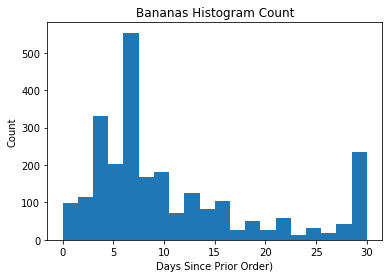

In [62]:
plt.hist(bananas.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order)')
plt.ylabel('Count')
plt.title('Bananas Histogram Count')

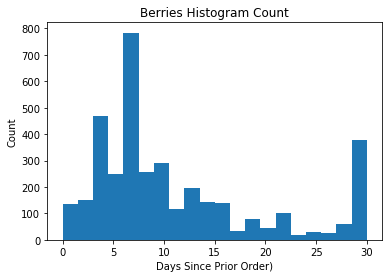

In [64]:
plt.hist(berry.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order)')
plt.ylabel('Count')
plt.title('Berries Histogram Count')

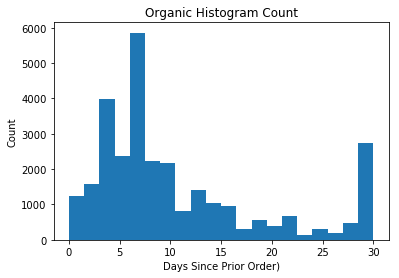

In [65]:
plt.hist(organic.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order)')
plt.ylabel('Count')
plt.title('Organic Histogram Count')

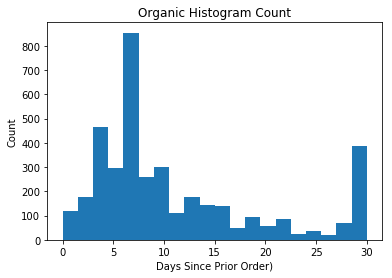

In [66]:
plt.hist(yogurt.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order)')
plt.ylabel('Count')
plt.title('Organic Histogram Count')

In [67]:
difference_mean_1 = berry_mean - bananas_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_1 = np.sqrt(bananas_std**2/len(bananas) + berry_std**2/len(berry))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3558726461689492)
('Standard error of the mean: ', 0.21298680635553999)


In [77]:
difference_mean_2 = berry_mean - organic_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_2 = np.sqrt(organic_std**2/len(organic) + berry_std**2/len(berry))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3188411305319949)
('Standard error of the mean: ', 0.21086722479443279)


In [78]:
difference_mean_3 = berry_mean - yogurt_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_3 = np.sqrt(yogurt_std**2/len(yogurt) + berry_std**2/len(berry))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3188411305319949)
('Standard error of the mean: ', 0.21086722479443279)


In [79]:
difference_mean_4 = organic_mean - bananas_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_4 = np.sqrt(bananas_std**2/len(bananas) + organic_std**2/len(organic))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3188411305319949)
('Standard error of the mean: ', 0.21086722479443279)


In [80]:
difference_mean_5 = organic_mean - yogurt_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_5 = np.sqrt(yogurt_std**2/len(yogurt) + organic_std**2/len(organic))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3188411305319949)
('Standard error of the mean: ', 0.21086722479443279)


In [81]:
difference_mean_6 = yogurt_mean - bananas_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem_6 = np.sqrt(bananas_std**2/len(bananas) + yogurt_std**2/len(yogurt))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 0.3188411305319949)
('Standard error of the mean: ', 0.21086722479443279)


In [73]:
z_score_difference_1 = (difference_mean_1 - 0)/difference_sem_1
z_score_difference_1

1.5120468856306246

In [74]:
p_value_difference_1 = 1-scipy.stats.norm.cdf(z_score_difference_1)
p_value_difference_1 * 100

6.5260967724457437

In [82]:
z_score_difference_2 = (difference_mean_2 - 0)/difference_sem_2
z_score_difference_2

3.5068538215860281

In [83]:
p_value_difference_2 = 1-scipy.stats.norm.cdf(z_score_difference_2)
p_value_difference_2 * 100

0.022671908309279676

In [84]:
z_score_difference_3 = (difference_mean_3 - 0)/difference_sem_3
z_score_difference_3

0.19368945514558475

In [85]:
p_value_difference_3 = 1-scipy.stats.norm.cdf(z_score_difference_3)
p_value_difference_3 * 100

42.320952453107218

In [87]:
z_score_difference_4 = (difference_mean_4 - 0)/difference_sem_4
z_score_difference_4

-0.89771131679456206

In [88]:
p_value_difference_4 = 1-scipy.stats.norm.cdf(z_score_difference_4)
p_value_difference_4 * 100

81.533026271417413

In [90]:
z_score_difference_5 = (difference_mean_5 - 0)/difference_sem_5
z_score_difference_5

-3.3232640543862324

In [91]:
p_value_difference_5 = 1-scipy.stats.norm.cdf(z_score_difference_5)
p_value_difference_5 * 100

99.955514673759765

In [93]:
z_score_difference_6 = (difference_mean_6 - 0)/difference_sem_6
z_score_difference_6

1.5120468856306246

In [94]:
p_value_difference_6 = 1-scipy.stats.norm.cdf(z_score_difference_6)
p_value_difference_6 * 100

6.5260967724457437

In [ ]:
str.contains('pandas', case=False)

In [ ]:
rpt[rpt['STK_ID'].isin(stk_list)]

In [ ]:
from collections import defaultdict, Counter
from scipy.stats import mode

df = pd.DataFrame([], columns = ['user_id','reordered','department_id','mode_UID_minus_one_val','mean_UID_minus_one_val','last_value'])
user_id_dict = defaultdict(list)
user_id_dict
df